In [2]:
#Needed Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import re

import os
import sys

from tqdm import tqdm

import json
from pathlib import Path

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
tqdm.pandas()

sns.set(font_scale = 1.25)
sns.set_style("whitegrid")

categories = ['General Relation', 'Duplication', 'Temporal/Causal', 'Composition', 'Workflow']
cat_short = [ 'Com.', 'Gen.', 'Dup.', 'T/C', 'Wor.']
SOURCES = ['Apache', 'Hyperledger', 'IntelDAOS', 'JFrog', 'Jira', 'JiraEcosystem', 'MariaDB', 'Mindville', 'MongoDB', 'Qt', 'RedHat', 'Sakai', 'SecondLife', 'Sonatype', 'Spring']

pd.set_option('display.max_rows', None)

In [4]:
def load_data(source):
    #Loading Issues
    filename = '../data/crawl/issues_'+source.lower()+'.csv'
    issues = pd.read_csv(filename, encoding="UTF-8", low_memory=False, sep=';', index_col=['issue_id'])
    
    #Loading Links
    filename = '../data/crawl/clean_links_'+source.lower()+'.csv'
    links = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=0, sep=';')
    
    return issues, links

In [5]:
link_dict = {}
issue_dict = {}

for s in SOURCES:
    print(s.upper())
    issues, links = load_data(s)
    link_dict[s] = links
    issue_dict[s] = issues

APACHE
HYPERLEDGER
INTELDAOS
JFROG
JIRA
JIRAECOSYSTEM
MARIADB
MINDVILLE
MONGODB
QT
REDHAT
SAKAI
SECONDLIFE
SONATYPE
SPRING


In [6]:
for s in SOURCES:
    print(s.upper())
    issues = issue_dict[s]
    print(len(issues.projectid.unique()))
    print(issues.projectid.unique())

APACHE
644
['ZooKeeper' 'Zeppelin' 'Apache Zipkin' 'Zeta Components'
 'Apache YuniKorn' 'Yetus' 'Hadoop YARN' 'XWork' 'XmlSchema' 'XML-RPC'
 'XML Commons' 'XMLBeans' 'Xerces2-J' 'XMLGraphicsCommons' 'Xerces-P'
 'Xerces-C++' 'XBean' 'XAP' 'XalanJ2' 'XalanC' 'Struts 2' 'WSS4J' 'WSRP4J'
 'Axis-WSIF' 'WS-Commons' 'Wookie' 'Woden' 'Wink' 'Wicket'
 'Apache Whirr (retired)' 'Whimsy' 'Weex' 'Apache Whisker'
 'Commons Weaver' 'Apache Wayang' 'Wave' 'Maven Wagon' 'WADI' 'VYSPER'
 'Velocity' 'VCL' 'VXQuery (Retired)' 'Velocity Tools' 'Commons VFS'
 'Velocity Sandbox' 'Commons Validator' 'Usergrid' 'UIMA' 'Apache Unomi'
 'Apache Twill (Retired)' 'Tuweni' 'Tuscany' 'Test Project' 'TSIK'
 'Traffic Server' 'TripleSoup' 'MyFaces Trinidad' 'Turbine'
 'Axis2 Transports' 'Commons Transaction' 'Apache Training'
 'Apache Trafodion' 'Torque issues (old)' 'Torque' 'TOREE' 'Tiles Request'
 'TomEE' 'Avalon Metro Tools' 'MyFaces Tomahawk' 'MyFaces Tobago' 'BRAND'
 'TinkerPop' 'Tiles Showcase' 'Tiles Shared Reso

209
['XNIO' 'WINDUPRULE - Red Hat Application Migration Toolkit rules'
 'WINDUP - Red Hat Application Migration Toolkit'
 'Web Terminal for OpenShift' 'OpenShift Workloads' 'Wise' 'WildFly'
 'Windows Container' 'WildFly WIP' 'WildFly Transaction Client'
 'WildFly Naming Client' 'WildFly Maven Plugin' 'JBoss WFK 2'
 'WildFly Core' 'WildFly Discovery' ' WildFly Client Configuration'
 'WildFly Arquillian' 'Weld' 'virtio-networking' 'User Experience'
 'Undertow' 'WildFly EJB HTTP Client' 'Distributed Tracing'
 'Red Hat 3scale API Management' 'Test Scenarios' 'Thorntail'
 'Teiid Spring Boot' 'Teiid Designer' 'TEST Defect Tracking Project'
 'Teiid Web Tooling' 'Teiid Web Console' 'Teiid' 'Kiali QE' 'SwitchYard'
 'OpenShift Storage' 'WildFly OpenSSL Natives' 'OpenShift Pipelines'
 'JBoss Enterprise SOA Platform' 'OpenShift Specialist Platform Team'
 'Snowdrop' 'ShrinkWrap' 'Spring Boot & Cloud' 'ShrinkWrap Resolvers'
 'PicketBox ' 'OpenShift SDN' 'RiftSaw' 'OpenShift Runtimes'
 'Red Hat Proce

In [32]:
def print_linktypes(SOURCE):
    
    issues = issue_dict[SOURCE]
    links = link_dict[SOURCE]
    
    num_links = len(links)
    num_issues = len(issues)
    
    issue_set = set(issues.index.values)
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))

    projects = issues[['projectid']]

    temp = links.join(projects, how = 'inner', on='issue_id_1')
    temp = temp.join(projects, how = 'inner', on='issue_id_2', lsuffix='_1', rsuffix='_2')

    temp['sameproject'] = (temp["projectid_1"]==temp["projectid_2"])

    blub = temp.linktype.value_counts().rename_axis('linktype').reset_index(name='counts')
    try:
        same_ratio = round(temp['sameproject'].value_counts().loc[True]/len(temp)*100, 2)
    except:
        same_ratio = 0
    try:
        cross_ratio = round(temp['sameproject'].value_counts().loc[False]/len(temp)*100, 2)
    except:
        cross_ratio = 0

    blub = links.linktype.value_counts().rename_axis('linktype').reset_index(name='counts')
    blub['source'] = SOURCE
    blub['percentages'] = blub['counts'].apply(lambda x: round(x/len(links),3)*100)
    blub['sameproject'] = 0
    blub['crossproject'] = 0
    for i in temp.linktype.value_counts().index:
        link_temp = temp[temp['linktype'] == i]
        try:
            same_ratio_temp = round(link_temp['sameproject'].value_counts().loc[True]/len(link_temp)*100, 2)
        except:
            same_ratio_temp = 0
        try:
            cross_ratio_temp = round(link_temp['sameproject'].value_counts().loc[False]/len(link_temp)*100, 2)
        except:
            cross_ratio_temp = 0
        link_index = blub.index[blub['linktype']==i]
        link_index = list(link_index)
        blub['sameproject'].iloc[link_index[0]] = same_ratio_temp
        blub['crossproject'].iloc[link_index[0]] = cross_ratio_temp
        
    return num_issues, num_links, len(links.linktype.unique()), round(len(link_set)/len(issue_set), 3), len(link_set), same_ratio, cross_ratio, blub

In [33]:
overview = pd.DataFrame(columns = ['Source', '#Issues', '#Links', '#Linktypes', '%IssuesWithLinks', '#LinkedIssues', "%SameProject", "%CrossProject"])
link_dist = pd.DataFrame(columns=['source', 'linktype', 'counts'])
j = 0
for s in SOURCES:
    i, l, ltu, pi, li, sr, cr, blub = print_linktypes(s)
    overview.loc[j] = [s, i, l, ltu, pi, li, sr, cr]
    
    j+=1
    
    frames = [link_dist, blub]
    #concatenate dataframes
    link_dist = pd.concat(frames, sort=False)

In [54]:
non_custom_types = (link_dist[link_dist['linktype']=='Subtask']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Epic-Relation']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Cloners']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Cloners (old)']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Relate']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Relates']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Related']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Reference']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Relationship']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Duplicate']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Blocker']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Blocked']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Blocks']['counts'].sum())

In [55]:
non_custom_types/link_dist.counts.sum()

0.8424065559083543

In [11]:
blub = overview[['Source', '#Issues', '#Links', '#Linktypes',
           '%IssuesWithLinks', 
           '%CrossProject',]]

blub['%IssuesWithLinks'] = blub['%IssuesWithLinks'].apply(lambda x: str(round(x*100,1))+'%')
blub['%CrossProject'] = blub['%CrossProject'].apply(lambda x: str(round(x,1))+'%')

print(blub.to_latex(index=False))  

\begin{tabular}{llllll}
\toprule
       Source & \#Issues & \#Links & \#Linktypes & \%IssuesWithLinks & \%CrossProject \\
\midrule
       Apache &  970929 & 242823 &         21 &            28.3\% &          5.3\% \\
  Hyperledger &   27914 &  16225 &          8 &            55.1\% &          4.6\% \\
    IntelDAOS &    5557 &   3222 &         10 &            55.5\% &          0.0\% \\
        JFrog &   14769 &   3206 &         11 &            29.8\% &          8.2\% \\
         Jira &  265343 &  98122 &         19 &            47.7\% &         43.9\% \\
JiraEcosystem &   40602 &  10911 &         18 &            32.8\% &          6.8\% \\
      MariaDB &   31229 &  14618 &          8 &            44.5\% &          2.5\% \\
    Mindville &    2134 &     44 &          4 &             4.0\% &          4.5\% \\
      MongoDB &   90629 &  37545 &         13 &            42.6\% &         11.3\% \\
           Qt &  140237 &  35855 &          8 &            28.9\% &          7.2\% \\
       Re

In [12]:
type_dict={'Backports': 'Workflow', 
           
    'Blocked': 'Temporal/Causal',
    'Blocker': 'Temporal/Causal',
    'Blocks': 'Temporal/Causal',
           
    'Bonfire Testing': 'Workflow', 
    'Bonfire testing': 'Workflow', 
    'Git Code Review': 'Workflow', 
    'Testing': 'Workflow',
           
    'Causality': 'Temporal/Causal', 
    'Cause': 'Temporal/Causal',
    'Caused': 'Temporal/Causal', 
    'Problem/Incident': 'Temporal/Causal',
           
    'Child-Issue': 'Composition', 
    'Parent Feature': 'Composition',
    'Parent/Child': 'Composition',
    'multi-level hierarchy [GANTT]': 'Composition',
    'Parent-Relation': 'Composition',
           
    'Cloners': 'Duplication', 
    'Cloners (old)': 'Duplication', 
           
    'Collection': 'Composition', 
    'Container': 'Composition', 
    'Contains(WBSGantt)': 'Composition', 
    'Incorporate': 'Composition', 
    'Incorporates': 'Composition', 
    'Part': 'Composition',
    'PartOf': 'Composition',
    'Superset': 'Composition', 
           
    'Completes': 'Workflow', 
    'Fixes': 'Workflow',
    'Resolve': 'Workflow',
           
    'Depend': 'Temporal/Causal', 
    'Dependency': 'Temporal/Causal', 
    'Dependent': 'Temporal/Causal', 
    'Depends': 'Temporal/Causal', 
    'Gantt Dependency': 'Temporal/Causal',
    'dependent': 'Temporal/Causal',
           
    'Derived': 'Workflow',
           
    'Detail': 'Workflow', 
           
    'Documentation': 'Workflow',
    'Documented': 'Workflow',
    
    'Duplicate': 'Duplication',
           
    'Epic': 'Composition', 
    'Epic-Relation': 'Composition',
    
    'Finish-to-Finish link (WBSGantt)': 'Temporal/Causal', 
    'Gantt End to End': 'Temporal/Causal', 
    'Gantt: finish-finish': 'Temporal/Causal',
    'finish-finish [GANTT]': 'Temporal/Causal', 
    
    'Gantt End to Start': 'Temporal/Causal', 
    'Gantt: finish-start': 'Temporal/Causal',
    'finish-start [GANTT]': 'Temporal/Causal',

    'Gantt Start to Start': 'Temporal/Causal', 
    
    'Gantt: start-finish': 'Temporal/Causal', 
    
    'Follows': 'Temporal/Causal', 
    'Sequence': 'Temporal/Causal', 
    
    'Implement': 'Workflow', 
    'Implements': 'Workflow', 
    
    'Issue split': 'Composition',
    'Split': 'Composition',
    'Work Breakdown': 'Composition',
    
    'Preceded By': 'Temporal/Causal', 
    
    'Reference': 'General Relation',
    'Relate': 'General Relation',
    'Related': 'General Relation', 
    'Relates': 'General Relation',
    'Relationship': 'General Relation',
    
    'Regression': 'Workflow', 
    
    'Replacement': 'Duplication',
    
    'Required': 'Temporal/Causal', 
    
    'Supercedes': 'Workflow',
    'Supersede': 'Workflow',
    'Supersession': 'Workflow', 
    
    'Test': 'Workflow', 
    'Tested': 'Workflow',
    
    'Trigger': 'Workflow',
           
    'Subtask': 'Composition'}

In [36]:
def print_cleaned_linktypes(SOURCE):  
    issues = issue_dict[SOURCE]
    links = link_dict[SOURCE]
    
    issue_set = set(issues.index.values)
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))

    links['category'] = links['linktype'].map(type_dict)
            
    projects = issues[['projectid']]

    temp = links.join(projects, how = 'inner', on='issue_id_1')
    temp = temp.join(projects, how = 'inner', on='issue_id_2', lsuffix='_1', rsuffix='_2')

    temp['sameproject'] = (temp["projectid_1"]==temp["projectid_2"])

    blub = links.category.value_counts().rename_axis('category').reset_index(name='counts')
    blub['source'] = SOURCE
    blub['percentageOfLinks'] = blub['counts'].apply(lambda x: round(x/len(links),10)*100)
    blub['percentagesOfIssues'] = 0
    blub['sameproject'] = 0
    blub['crossproject'] = 0
    for i in range(len(blub)):
        category = blub['category'].iloc[i]
        link_temp = temp[temp['category'] == category]
        lt_set = set(link_temp['issue_id_1']).union(set(link_temp['issue_id_2']))
        blub['percentagesOfIssues'].iloc[i] = round(len(lt_set)/len(issue_set),10)*100
        
        try:
            same_ratio_temp = round(link_temp['sameproject'].value_counts().loc[True]/len(link_temp)*100, 2)
        except:
            same_ratio_temp = 0
        try:
            cross_ratio_temp = round(link_temp['sameproject'].value_counts().loc[False]/len(link_temp)*100, 2)
        except:
            cross_ratio_temp = 0
            
        blub['sameproject'].iloc[i] = same_ratio_temp
        blub['crossproject'].iloc[i] = cross_ratio_temp
        
    return len(links.category.unique()), blub

In [37]:
overview_cl = pd.DataFrame(columns=['Source', '#Linktypes'])
cat_dist_cl = pd.DataFrame(columns=['source', 'category', 'counts'])
j = 0
for s in SOURCES:
    catu, blub = print_cleaned_linktypes(s)
    overview_cl.loc[j] = [s, catu]
    
    j+=1
    
    frames = [cat_dist_cl, blub]
    #concatenate dataframes
    cat_dist_cl = pd.concat(frames, sort=False)

In [38]:
cat_dist_cl.groupby(['category']).agg({'counts': ['sum'], 'percentageOfLinks': ['mean'], 'sameproject': ['mean'], 'crossproject': ['mean']})

,counts,percentageOfLinks,sameproject,crossproject
,sum,mean,mean,mean
category,,,,
Composition,190913,36.573187,98.617143,1.382857
Duplication,98178,16.760610,93.255333,6.744667
General Relation,218833,35.274554,88.752000,11.248000
Temporal/Causal,84236,11.434260,86.488667,13.511333
Workflow,15048,2.994501,84.305833,15.694167


In [39]:
pivot = pd.pivot_table(cat_dist_cl, values='percentageOfLinks', index=['source'],
                    columns=['category'], aggfunc=np.sum)
pivot = pivot[['Composition', 'General Relation', 'Duplication', 'Temporal/Causal', 'Workflow']]
pivot

category,Composition,General Relation,Duplication,Temporal/Causal,Workflow
source,,,,,
Apache,42.436260,28.532717,11.905791,13.878010,3.247221
Hyperledger,67.759630,17.121726,6.810478,8.265023,0.043143
IntelDAOS,71.539417,12.135320,8.131595,8.100559,0.093110
JFrog,37.648160,27.230193,20.555209,8.265752,6.300686
Jira,5.143597,63.949981,24.520495,2.850533,3.535395
JiraEcosystem,46.677665,23.279259,17.541930,11.593804,0.907341
MariaDB,20.584211,51.060337,9.399371,18.956082,NaN
Mindville,NaN,43.181818,54.545455,2.272727,NaN
MongoDB,8.251432,49.125050,17.597550,20.263684,4.762285


In [40]:
print(pivot.round(1).to_latex())

\begin{tabular}{lrrrrr}
\toprule
category &  Composition &  General Relation &  Duplication &  Temporal/Causal &  Workflow \\
source        &              &                   &              &                  &           \\
\midrule
Apache        &         42.4 &              28.5 &         11.9 &             13.9 &       3.2 \\
Hyperledger   &         67.8 &              17.1 &          6.8 &              8.3 &       0.0 \\
IntelDAOS     &         71.5 &              12.1 &          8.1 &              8.1 &       0.1 \\
JFrog         &         37.6 &              27.2 &         20.6 &              8.3 &       6.3 \\
Jira          &          5.1 &              63.9 &         24.5 &              2.9 &       3.5 \\
JiraEcosystem &         46.7 &              23.3 &         17.5 &             11.6 &       0.9 \\
MariaDB       &         20.6 &              51.1 &          9.4 &             19.0 &       NaN \\
Mindville     &          NaN &              43.2 &         54.5 &              2.

In [41]:
cat_order = ['Composition', 'General Relation', 'Duplication', 'Temporal/Causal', 'Workflow']

In [42]:
pivot.median()

category
Composition         34.468752
General Relation    29.365079
Duplication         14.257228
Temporal/Causal     11.593804
Workflow             2.077281
dtype: float64

In [43]:
tidy2 = cat_dist_cl.melt(id_vars='category').rename(columns=str.title)
tidy = tidy2[(tidy2['Variable']=='percentageOfLinks')]

In [44]:
tidy_short = tidy[tidy['Category'].isin(categories)]

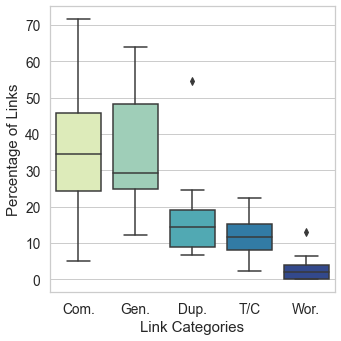

In [45]:
fig = plt.gcf()
fig.set_size_inches(5, 5)

# plt.xticks(rotation=45)
ax = sns.boxplot(x='Category', y='Value', data=tidy_short, order=cat_order,  palette="YlGnBu")

ax.set(xlabel ="Link Categories", ylabel = "Percentage of Links")

ax.set_xticklabels(cat_short)

plt.tight_layout()
        
plt.savefig('pictures/link_cat_usage_cleaned.png', dpi = 300)


In [46]:
tidy3 = cat_dist_cl.melt(id_vars='category').rename(columns=str.title)
tidy4 = tidy3[(tidy3['Variable']=='percentagesOfIssues')]

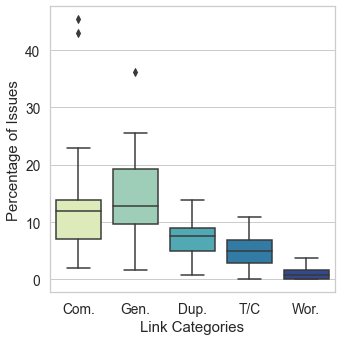

In [47]:
fig = plt.gcf()
fig.set_size_inches(5, 5)

# plt.xticks(rotation=45)
ax = sns.boxplot(x='Category', y='Value', data=tidy4, order=cat_order,  palette="YlGnBu")

ax.set(xlabel ="Link Categories", ylabel = "Percentage of Issues")

ax.set_xticklabels(cat_short)

plt.tight_layout()
        
plt.savefig('pictures/link_cat_usage_issues_cleaned.png', dpi = 300)


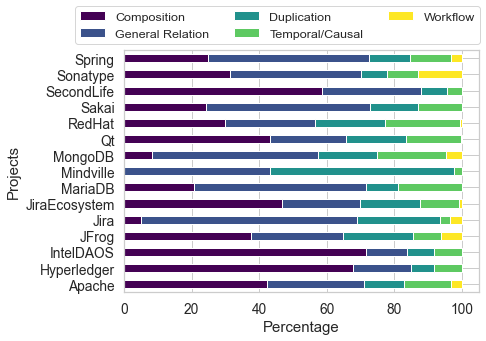

In [48]:
f, (ax) = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

fig = plt.gcf()
# fig.set_size_inches(10, 10)

ax = pivot.plot(kind='barh', stacked=True, mark_right = True, ax=ax, cmap="viridis")
ax.set(xlabel ="Percentage", ylabel = "Projects")

plt.legend(bbox_to_anchor=(-0.155, 1, 1, 0), ncol=3, fontsize='small')

plt.tight_layout()

ax.figure.savefig("pictures/link_cat_distribution_cleaned.png")